In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import gym
env = gym.make('CartPole-v0')

/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [3]:
upperBounds = env.observation_space.high
lowerBounds = env.observation_space.low
cartVelocityMin = -3
cartVelocityMax = 3
poleAngleVelocityMin = -10
poleAngleVelocityMax = 10
upperBounds[1] = cartVelocityMax
upperBounds[3] = poleAngleVelocityMax
lowerBounds[1] = cartVelocityMin
lowerBounds[3] = poleAngleVelocityMin

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
!pip install mushroom_rl
from mushroom_rl.features.basis import PolynomialBasis, GaussianRBF
from mushroom_rl.features import Features

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.9/239.9 kB 19.0 MB/s eta 0:00:00
  Created wheel for mushroom_rl: filename=mushroom_rl-1.9.1-py3-none-any.whl size=1722302 sha256=1ee2372a91580c63cafba9c26e049ef00f79147177542943701fa744a9ff2a16
  Stored in directory: /root/.cache/pip/wheels/73/49/df/15bbda01518725052a17b12976dcfdd9dd3463a79a68274ccc
Successfully built mushroom_rl


In [26]:
class CartPole_RLSPI():

    def __init__(self, config, gravity=9.8, length=0.5, force_mag=10) -> None:
        self.env = gym.make('CartPole-v0')
        self.env.reset()
        self.env.gravity = gravity
        self.length = length
        self.force_mag = force_mag
        self.n_actions = env.action_space.n 
        self.n_episodes = config["n_episodes"]
        self.n_bins = config["n_bins"]
        self.lowerBounds = config["lowerBounds"]
        self.upperBounds = config["upperBounds"]

        self.n_states = self.n_bins[0]*self.n_bins[1]*self.n_bins[2]*self.n_bins[3]

        self.n_actions = self.env.action_space.n

        self.policy = np.random.randint(0, 2, (self.n_bins[0],self.n_bins[1],self.n_bins[2],self.n_bins[3], 1))

        self.n_features = config['n_features']
        self.epsilon = config['epsilon']

        self.alpha = config['alpha']

        self.features = self.get_basis()

        self.actions = np.arange(self.n_actions)

        self.phi_sa = self.get_phi_sa(self.actions)


    def get_basis(self):
        basis = []
        s1 = np.array([-2,-1,0,1, 2])
        s2 = np.array([-1.5,0, 1.5])
        s3 = np.array([-0.2,0, 0.2])
        s4 = np.array([-5,0, 5])
        s5 = np.array([0, 1])
        for i in s1:
            for j in s2:
                for k in s3:
                    for l in s4:
                        for m in s5:
                            basis.append(GaussianRBF(np.array([i,j,k,l, m]), np.array([2])))
        features = Features(basis_list=basis)

        return features
    

    def get_phi_sa(self, actions):
        
        phi_sa = np.zeros((self.n_bins[0],self.n_bins[1],self.n_bins[2],self.n_bins[3], self.n_features, len(actions)))

        for i in range(self.n_bins[0]):
            a = np.linspace(self.lowerBounds[0],self.upperBounds[0],self.n_bins[0])[i]
            for j in range(self.n_bins[1]):
                b = np.linspace(self.lowerBounds[1],self.upperBounds[1],self.n_bins[1])[j]
                for k in range(self.n_bins[2]):
                    c = np.linspace(self.lowerBounds[2],self.upperBounds[2],self.n_bins[2])[k]
                    for l in range(self.n_bins[3]):
                        d = np.linspace(self.lowerBounds[3],self.upperBounds[3],self.n_bins[3])[l]
                        for action in actions:
                            phi_sa[i,j,k,l,:,action] = phi_sa[i,j,k,l,:,action]/np.linalg.norm(phi_sa[i,j,k,l,:,action])
                            phi_sa[i,j,k,l,:,action] = self.features(np.array([a,b,c,d,action]))
                            phi_sa[i,j,k,l,:,action] = phi_sa[i,j,k,l,:,action]/np.linalg.norm(phi_sa[i,j,k,l,:,action])

        # print(phi_sa.shape)

        return phi_sa
    


    def returnIndexState(self,state):
        position = state[0]
        velocity = state[1]
        angle    = state[2]
        angularVelocity = state[3]
            
        cartPositionBin = np.linspace(self.lowerBounds[0],self.upperBounds[0],self.n_bins[0])
        cartVelocityBin = np.linspace(self.lowerBounds[1],self.upperBounds[1],self.n_bins[1])
        poleAngleBin = np.linspace(self.lowerBounds[2],self.upperBounds[2],self.n_bins[2])
        poleAngleVelocityBin = np.linspace(self.lowerBounds[3],self.upperBounds[3],self.n_bins[3])
            
        indexPosition = np.maximum(np.digitize(position,cartPositionBin)-1,0)
        indexVelocity = np.maximum(np.digitize(velocity,cartVelocityBin)-1,0)
        indexAngle = np.maximum(np.digitize(angle,poleAngleBin)-1,0)
        indexAngularVelocity = np.maximum(np.digitize(angularVelocity,poleAngleVelocityBin)-1,0)
            
        return tuple([indexPosition,indexVelocity,indexAngle,indexAngularVelocity]) 

    def generate_step_sizes(self, n):
        """
        Generates a deterministic sequence of step sizes that satisfy the standard Robbins-Munro stochastic conditions 
        for stochastic approximation.
        
        Args:
            n (int): The number of step sizes to generate.
        
        Returns:
            A numpy array of shape (n,) containing the step sizes.
        """
        
        n = 100000
        # Generate the sequence of step sizes according to the Robbins-Munro stochastic conditions
        step_sizes = np.zeros(n)
        for i in range(n):
            step_sizes[i] = 1 / ((i+1) * np.sqrt(i+1))
        
        return list(step_sizes)
  

    def simulateEpisodes(self):
        # here we loop through the episodes

        sum_rewards = []
        avg_rewards = []
        for indexEpisode in range(self.n_episodes):
                
            # list that stores rewards per episode - this is necessary for keeping track of convergence 
            rewardsEpisode=[]

            history = []

            w = np.random.random((self.n_features, 1))
                
            # reset the environment at the beginning of every episode
            stateS = self.env.reset()
            stateS = list(stateS)

            s_0 = self.returnIndexState(stateS)

            a_0 = self.policy[s_0][0]

            (stateSprime, reward, terminalState,_) = self.env.step(a_0)          
                
            stateSprime=list(stateSprime)
                
            s_1 = self.returnIndexState(stateSprime)
            a_1 = self.policy[s_1][0]


            z_0 = self.phi_sa[s_0[0], s_0[1], s_0[2], s_0[3], :, a_0].reshape(-1, 1)
            A_0 = z_0@(self.alpha*self.phi_sa[s_1[0], s_1[1], s_1[2], s_1[3],:,a_1].reshape(-1, 1).T - self.phi_sa[s_0[0], s_0[1], s_0[2], s_0[3],:,a_0].reshape(-1, 1).T)
            B_0 = (self.phi_sa[s_0[0], s_0[1], s_0[2], s_0[3], :, a_0].reshape(-1, 1))@(self.phi_sa[s_0[0], s_0[1], s_0[2], s_0[3], :, a_0].reshape(-1, 1).T)

            history.append((0, s_0, a_0, 0,
                            s_1, z_0, A_0,
                            B_0))
            

            print("Simulating episode {}".format(indexEpisode))
                
            # here we step from one state to another
            # this will loop until a terminal state is reached
            terminalState=False

            gammas = self.generate_step_sizes(self)
            t = 0
            
            while not terminalState:
                # return a discretized index of the state
                    
                stateSIndex = self.returnIndexState(stateS)
                    
                # select an action on the basis of the current state, denoted by stateS
                actionA = self.policy[stateSIndex]

                if terminalState:
                    stateSprime, reward, terminalState,_ = stateS, 0, True, None
                else:
                    (stateSprime, reward, terminalState,_) = self.env.step(actionA[0])          
                    
                rewardsEpisode.append(reward)
                    
                stateSprime=list(stateSprime)
                    
                stateSprimeIndex = self.returnIndexState(stateSprime)
                
                # print("Using Gamma: ", {gammas[t]}, " t: ", t)                
                history, w_new = self.rlspe(self.phi_sa, history, self.policy, w, stateSIndex, stateSprimeIndex, actionA, reward, gamma = gammas[t])
                                       
                stateS = stateSprime

                diff = np.linalg.norm(w_new - w)

                if diff < self.epsilon:
                    break

                w = w_new

                t+=1
            
            # update policy
            self.updatePolicy(w, self.phi_sa[:,:,:,:,:,:].reshape(-1, self.n_features, self.n_actions), self.actions)
    
            print("Sum of rewards {}".format(np.sum(rewardsEpisode))) 
            
            if (len(avg_rewards) == 0):
              avg_rewards.append(np.sum(rewardsEpisode))
            else:
              new_avg = (avg_rewards[-1] * len(avg_rewards) + np.sum(rewardsEpisode) ) / (len(avg_rewards) + 1)
              avg_rewards.append(new_avg)
            
            sum_rewards.append(np.sum(rewardsEpisode))   

            print("Cumulative Average Reward: {}".format(avg_rewards[-1]))

        plt.plot(avg_rewards)
        plt.xlabel("Episodes")
        plt.ylabel("Cumulative Average Reward")
        plt.show()

    def updatePolicy(self, w, phi_sa, actions):
        temp = np.einsum("sla,lj -> sja", phi_sa, w)
        temp = np.squeeze(temp, axis=1)
        temp_1 = np.argmax(temp, axis=1)
        self.policy = temp_1.reshape(self.n_bins[0], self.n_bins[1], self.n_bins[2], self.n_bins[3], 1)
        

    def sigma(self, u_s_a, v):
        temp = np.dot(u_s_a, v)
        return np.min(temp)


    def generate_uncertainty_set(self, n_states):
        x = 100
        U = np.zeros((x, n_states))
        for i in range(x):      
            random_numbers = [random.random() * 2 - 1 for i in range(n_states)]  # generate n random numbers between -1 and 1
            mean = sum(random_numbers) / n_states  # calculate the mean of the n numbers
            random_numbers = [(x - mean)/2 +1 for x in random_numbers]  # subtract the mean from each of the numbers
            U[i] = np.array(random_numbers)
        
        return U


    def rlspe(self, phi, history, curr_policy, w, s_t, s_t_plus_1, a_t, reward, alpha=0.1, lamda=0.9, gamma=0.01):
        # history - (t, s, a, r, s', z, A, B) tuples
        # curr_policy - ()
        # w - (L x 1)
        # phi - (S x L x |A|)

        t = history[-1][0] + 1
        z_t_minus_1 = history[-1][5]
        A_t_minus_1 = history[-1][6]
        B_t_minus_1 = history[-1][7]
        s_t_minus_1 = history[-1][1]
        a_t_plus_1 = curr_policy[s_t_plus_1][0]

        phi_s_t = phi[s_t[0], s_t[1], s_t[2], s_t[3], :, a_t[0]].reshape(-1, 1)

        phi_s_t_plus_1 = phi[s_t_plus_1[0], s_t_plus_1[1], s_t_plus_1[2], s_t_plus_1[3], :, a_t_plus_1].reshape(-1, 1)



        z_t = z_t_minus_1*(alpha*lamda) + phi_s_t


        A_t = (t/(t+1))*A_t_minus_1 + (1/(t+1))*z_t@(alpha*phi_s_t_plus_1.T - phi_s_t.T)


        B_t = (t/(t+1))*B_t_minus_1 + phi_s_t@phi_s_t.T


        C_t = 0
        b_t = 0

        U_s_a = self.generate_uncertainty_set(self.n_states)

        for (tau, s, a, r, s_prime, z, A, B) in history:

            C_t += z*self.sigma(U_s_a, phi[:,:,:,:,:,a_t].reshape(-1, self.n_features)@w)

            b_t += z*r
        
        C_t *= alpha/(t+1)
        b_t *= 1/(t+1)
            
        w_t_plus_1 = w + gamma*np.linalg.pinv(B_t)@(A_t@w + b_t + C_t)


        history.append((t, s_t, a_t, reward, s_t_plus_1, z_t, A_t, B_t))

        return history, w_t_plus_1
        
        

In [27]:
config = {
    "n_episodes": 50,
    "n_bins": (5, 5, 5, 5),
    "lowerBounds": lowerBounds,
    "upperBounds": upperBounds,
    "n_features": 270,
    "epsilon": 0.1,
    'alpha': 0.1,
}


In [28]:
x = CartPole_RLSPI(config, gravity=9.8)

Simulating episode 0
Sum of rewards 7.0
Cumulative Average Reward: 7.0
Simulating episode 1
Sum of rewards 9.0
Cumulative Average Reward: 8.0
Simulating episode 2
Sum of rewards 8.0
Cumulative Average Reward: 8.0
Simulating episode 3
Sum of rewards 7.0
Cumulative Average Reward: 7.75
Simulating episode 4
Sum of rewards 8.0
Cumulative Average Reward: 7.8
Simulating episode 5
Sum of rewards 9.0
Cumulative Average Reward: 8.0
Simulating episode 6
Sum of rewards 9.0
Cumulative Average Reward: 8.142857142857142
Simulating episode 7
Sum of rewards 7.0
Cumulative Average Reward: 8.0
Simulating episode 8
Sum of rewards 7.0
Cumulative Average Reward: 7.888888888888889
Simulating episode 9
Sum of rewards 9.0
Cumulative Average Reward: 8.0
Simulating episode 10
Sum of rewards 8.0
Cumulative Average Reward: 8.0
Simulating episode 11
Sum of rewards 8.0
Cumulative Average Reward: 8.0
Simulating episode 12
Sum of rewards 9.0
Cumulative Average Reward: 8.076923076923077
Simulating episode 13
Sum of re

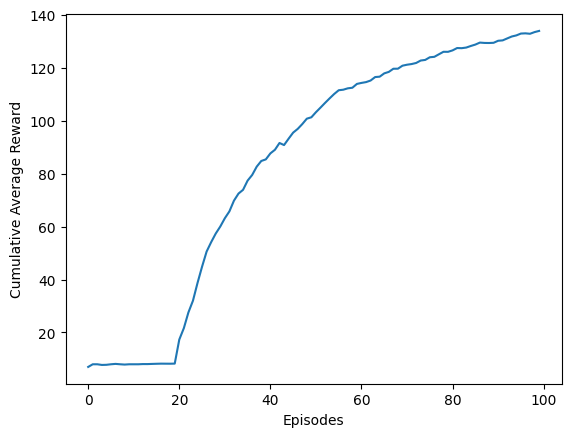

In [29]:
x.simulateEpisodes()

In [30]:
final_policy = x.policy

In [35]:
def evaluate_policy(policy, num_iterations, x):
  

  total_reward = 0
  for i in range(num_iterations):
        terminalState=False

        gammas = x.generate_step_sizes(x)
        t = 0
        rewardsEpisode = []

        stateS = x.env.reset()
        stateS = list(stateS)

        while not terminalState:
            # return a discretized index of the state                    
            stateSIndex = x.returnIndexState(stateS)                    
            # select an action on the basis of the current state, denoted by stateS
            actionA = policy[stateSIndex]
            if terminalState:
                stateSprime, reward, terminalState,_ = stateS, 0, True, None
            else:
                (stateSprime, reward, terminalState,_) = x.env.step(actionA[0])     
            rewardsEpisode.append(reward)                    
            stateSprime=list(stateSprime)                    
            stateSprimeIndex = x.returnIndexState(stateSprime)
            
            # print("Using Gamma: ", {gammas[t]}, " t: ", t)                
            # history, w_new = self.rlspe(self.phi_sa, history, self.policy, w, stateSIndex, stateSprimeIndex, actionA, reward, gamma = gammas[t])                                       
            stateS = stateSprime

            #diff = np.linalg.norm(w_new - w)

            # if diff < self.epsilon:
            #   break

            # w = w_new

            t+=1
        total_reward += np.sum(rewardsEpisode)
  
  return total_reward / num_iterations

In [36]:
evaluate_policy(final_policy, 50, x)

176.6

In [ ]:

g = 9.8
l=0.5
fm=10
change = np.linspace(-0.5, 0.8, 100)
parameter = g
arr = parameter + change * parameter
steps = []
for i in arr:
  x = CartPole_RLSPI(config, gravity=i)
  step = evaluate_policy(final_policy, 50, x)
  steps.append(step)

plt.plot(change, steps)

/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
def get_basis():
    basis = []
    s1 = np.array([-2, 2])
    s2 = np.array([-1.5, 1.5])
    s3 = np.array([-0.2, 0.2])
    s4 = np.array([-5, 5])
    s5 = np.array([0, 1])
    for i in s1:
        for j in s2:
            for k in s3:
                for l in s4:
                    for m in s5:
                        basis.append(GaussianRBF(np.array([i,j,k,l, m]), np.array([1])))
    features = Features(basis_list=basis)

    return features

In [ ]:
def get_phi_sa():

        n_actions = env.action_space.n 
        n_episodes = config["n_episodes"]
        n_bins = config["n_bins"]
        lowerBounds = config["lowerBounds"]
        upperBounds = config["upperBounds"]
        n_features = config["n_features"]

        n_states = n_bins[0]*n_bins[1]*n_bins[2]*n_bins[3]

        features = get_basis()

        actions = np.arange(n_actions)
        
        phi_sa = np.zeros((n_bins[0],n_bins[1],n_bins[2],n_bins[3],n_features, len(actions)))

        for i in range(n_bins[0]):
            a = np.linspace(lowerBounds[0],upperBounds[0],n_bins[0])[i]
            for j in range(n_bins[1]):
                b = np.linspace(lowerBounds[1],upperBounds[1],n_bins[1])[j]
                for k in range(n_bins[2]):
                    c = np.linspace(lowerBounds[2],upperBounds[2],n_bins[2])[k]
                    for l in range(n_bins[3]):
                        d = np.linspace(lowerBounds[3],upperBounds[3],n_bins[3])[l]
                        for action in actions:
                            phi_sa[i,j,k,l,:,action] = features(np.array([a,b,c,d,action]))
                            phi_sa[i,j,k,l,:,action] = phi_sa[i,j,k,l,:,action]/np.linalg.norm(phi_sa[i,j,k,l,:,action])

        print(phi_sa.shape)


        return phi_sa

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
phi_sa = get_phi_sa()

(5, 5, 5, 5, 32, 2)


In [ ]:
phi_sa[0,0,0,0,:,0].shape

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(32,)

In [ ]:
phi_sa[0,0,0,0,:,0]

array([7.63341841e-001, 2.80817770e-001, 1.05638612e-087, 3.88622736e-088,
       5.45991128e-001, 2.00858911e-001, 7.55595226e-088, 2.77967950e-088,
       1.16256808e-008, 4.27684895e-009, 1.60887392e-095, 5.91871640e-096,
       8.31543383e-009, 3.05907715e-009, 1.15077000e-095, 4.23344624e-096,
       1.60623949e-017, 5.90902487e-018, 2.22286926e-104, 8.17747900e-105,
       1.14888569e-017, 4.22651424e-018, 1.58993891e-104, 5.84905837e-105,
       2.44629950e-025, 8.99943291e-026, 3.38542538e-112, 1.24542840e-112,
       1.74975057e-025, 6.43697262e-026, 2.42147374e-112, 8.90810406e-113])

In [ ]:
phi_sa[0,0,0,0,:,0]/np.linalg.norm(phi_sa[0,0,0,0,:,0])

array([7.63341841e-001, 2.80817770e-001, 1.05638612e-087, 3.88622736e-088,
       5.45991128e-001, 2.00858911e-001, 7.55595226e-088, 2.77967950e-088,
       1.16256808e-008, 4.27684895e-009, 1.60887392e-095, 5.91871640e-096,
       8.31543383e-009, 3.05907715e-009, 1.15077000e-095, 4.23344624e-096,
       1.60623949e-017, 5.90902487e-018, 2.22286926e-104, 8.17747900e-105,
       1.14888569e-017, 4.22651424e-018, 1.58993891e-104, 5.84905837e-105,
       2.44629950e-025, 8.99943291e-026, 3.38542538e-112, 1.24542840e-112,
       1.74975057e-025, 6.43697262e-026, 2.42147374e-112, 8.90810406e-113])

In [ ]:
def generate_step_sizes(n):
    """
    Generates a deterministic sequence of step sizes that satisfy the standard Robbins-Munro stochastic conditions 
    for stochastic approximation.
    
    Args:
        n (int): The number of step sizes to generate.
    
    Returns:
        A numpy array of shape (n,) containing the step sizes.
    """
    import numpy as np
    
    # Generate the sequence of step sizes according to the Robbins-Munro stochastic conditions
    step_sizes = np.zeros(n)
    for i in range(n):
        step_sizes[i] = 1 / ((i+1) * np.sqrt(i+1))
    
    return step_sizes

In [ ]:
sum(generate_step_sizes(10000000))

2.611742893169012

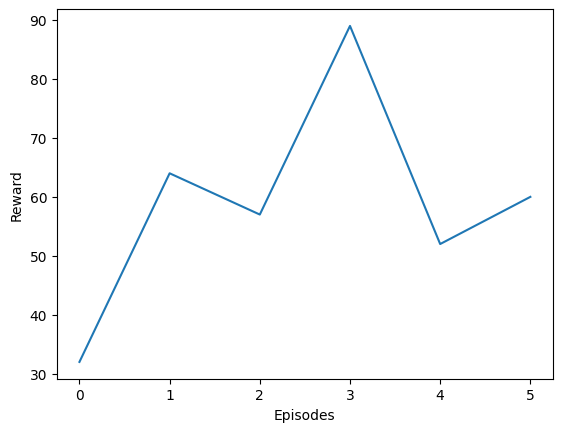

In [ ]:
plt.plot([32,64,57,89,52,60])
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.show()